In [1]:
from abc import ABC, abstractmethod
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm

import lib  #helper functions

In [2]:
class DecayingEpsilon:
  def __init__(self, initial_value=1, decay_per_step=0.99) -> None:
    self.initial_value = initial_value
    self.value = initial_value
    self.decay_per_step = decay_per_step

  def decay(self):
    self.value *= self.decay_per_step

In [3]:
class Agent(ABC):
  def __init__(self, env: gym.Env, epsilon=0.1, alpha=0.1, gamma=1, num_tilings=8,
               tiles_per_tiling=10):
    self.env = env
    self.epsilon = epsilon  # epsilon greedy
    self.alpha = alpha/num_tilings  # learning rate
    self.gamma = gamma  # discount factor
    self.num_tilings = num_tilings
    self.tiles_per_tiling = tiles_per_tiling

    self.tile_coder = lib.TileCoder(self.num_tilings,
                                    self.tiles_per_tiling,
                                    list(zip(env.observation_space.low,
                                             env.observation_space.high)))

    self.thetas = None
    self.reset()

  def Q(self, state, action) -> float:
    features = self.tile_coder.encode(state)  # binary vec

    return np.sum(self.thetas[action] * features)

  def select_action(self, state, greedy=False) -> int:
    # epsilon greedy
    epsilon = self.epsilon if not isinstance(self.epsilon,
                                             DecayingEpsilon) else self.epsilon.value
    to_explore = np.random.rand() < epsilon

    if greedy or not to_explore:
      return np.argmax([self.Q(state, a) for a in range(self.env.action_space.n)])
    else:
      return self.env.action_space.sample()

  @abstractmethod
  def update(self, state, action, reward, next_state, next_action, done) -> None:
    pass

  def reset(self):
    # params setup
    self.thetas = np.random.uniform(-0.001, 0.001,
                                    (env.action_space.n, self.tile_coder.total_tiles))


class ExpectedSARSA(Agent):

  def update(self, state, action, reward, next_state, next_action, done) -> None:
    y = np.mean(
      [self.Q(next_state, a) for a in range(self.env.action_space.n)]) if not done else 0
    y_hat = self.Q(state, action)

    td_error = reward + self.gamma * y - y_hat if not done else reward
    features = self.tile_coder.encode(state)

    self.thetas[action] += self.alpha * td_error * features


class QLearning(Agent):

  def update(self, state, action, reward, next_state, next_action, done) -> None:
    y_hat = self.Q(state, action)
    y = max([self.Q(next_state, a) for a in range(self.env.action_space.n)]) if not done else 0

    td_error = reward + self.gamma * y - y_hat if not done else reward
    features = self.tile_coder.encode(state)

    self.thetas[action] += self.alpha * td_error * features


In [4]:
def run_experiment(agent, num_runs, num_episodes):
  performances_across_runs = np.zeros(num_episodes)

  with tqdm(total=num_runs * num_episodes) as pbar:
    for run in range(num_runs):
      agent.reset()
      for episode in range(num_episodes):
        # initialize env 
        reward_throughout_ep = 0
        state, info = agent.env.reset()
        state = np.double(state)
        is_terminal = False
        truncated = False

        while not is_terminal and not truncated:
          action = agent.select_action(state)

          next_state, reward, is_terminal, truncated, info = agent.env.step(action)
          next_state = np.double(next_state)

          reward_throughout_ep += reward

          next_action = agent.select_action(next_state)

          agent.update(state,
                       action,
                       reward,
                       next_state,
                       next_action,
                       is_terminal or truncated)

          state, action = next_state, next_action
          
          if isinstance(agent.epsilon, DecayingEpsilon):
            agent.epsilon.decay()

        performances_across_runs[episode] += reward_throughout_ep

        pbar.update(1)

  return performances_across_runs / num_runs

100%|██████████| 50000/50000 [08:09<00:00, 102.22it/s]


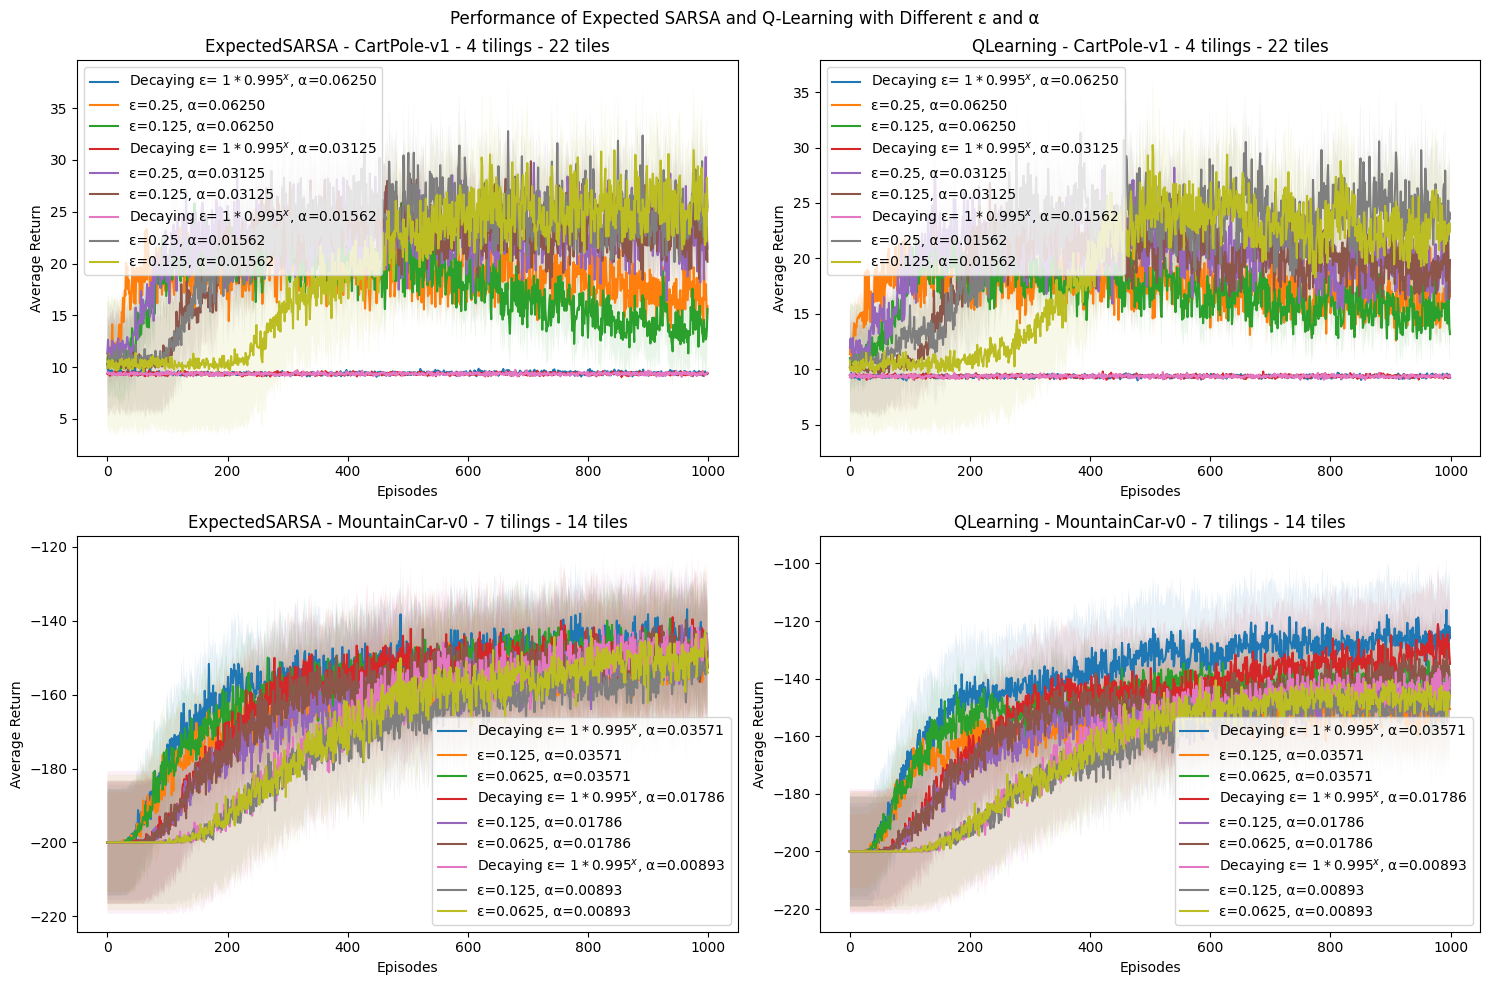

In [7]:
envs = [gym.make('CartPole-v1'), gym.make('MountainCar-v0')]
agents = [ExpectedSARSA, QLearning]

alphas = [1 / 4, 1 / 8, 1 / 16]

epsilons = {
  'CartPole-v1': [DecayingEpsilon(decay_per_step=0.995), 1 / 4, 1 / 8],
  'MountainCar-v0': [DecayingEpsilon(decay_per_step=0.995), 1 / 8, 1 / 16]
}

gammas = {
  'CartPole-v1': 0.99,
  'MountainCar-v0': 1
}

tilings = {
  'CartPole-v1': {
    'tilings': 4,
    'tiles': 22
  },
  'MountainCar-v0': {
    'tilings': 7,
    'tiles': 14
  }
}

NUM_RUNS = 50
NUM_EPISODES = 1000

n_envs = len(envs)
n_agents = len(agents)
n_epsilons = len(epsilons)
n_alphas = len(alphas)

n_plots = n_envs * n_agents * n_epsilons * n_alphas

fig, axs = plt.subplots(nrows=len(envs), ncols=len(agents), figsize=(15, 10))

if len(envs) * len(agents) > 1:
  axs = axs.flatten()

for agent_idx, agent in enumerate(agents):
  for env_idx, env in enumerate(envs):

    env_name = env.unwrapped.spec.id
    ax = axs[env_idx * len(agents) + agent_idx] if len(envs) * len(agents) > 1 else axs

    for alpha in alphas:
      for epsilon in epsilons[env_name]:
        exp_agent = agent(env, 
                          epsilon=epsilon, 
                          alpha=alpha, 
                          gamma=gammas[env_name],
                          num_tilings=tilings[env_name]['tilings'],
                          tiles_per_tiling=tilings[env_name]['tiles'])
        
        results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

        alpha_str = "{:.5f}".format(alpha / exp_agent.num_tilings)
        if isinstance(epsilon, DecayingEpsilon):
          label = f'Decaying ε= ${epsilon.initial_value} * {epsilon.decay_per_step}^x$, α={alpha_str}'
        else:
          label = f'ε={epsilon}, α={alpha_str}'

        ax.plot(results, label=label)

        std_results = np.std(results, axis=0)
        ax.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                        alpha=0.1)

    ax.set_title(
      f'{agent.__name__} - {env.spec.id} - {tilings[env_name]["tilings"]} tilings - {tilings[env_name]["tiles"]} tiles')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Average Return')

    ax.legend()

# Add an overall title and adjust layout
plt.suptitle('Performance of Expected SARSA and Q-Learning with Different ε and α')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()